# Autoencodeur

Dataset IMDB_WIKI required for training, see instructions in readme.md

##  Imports

In [19]:
import numpy as np
import pandas as pd 
import os

from scipy.io import loadmat
import cv2
import matplotlib.pyplot as plt
from datetime import date
import time

# from random import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras import Input, Model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import UpSampling2D, LeakyReLU, Lambda, Conv2DTranspose
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from keras import backend as K
from keras.layers import Reshape, concatenate, LeakyReLU, Lambda
from keras.callbacks import TensorBoard
from keras.layers import Activation

#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

## Chargement dataSet

In [2]:
#Définit le path vers les différents folders utiles

def path_var(dest):
    global images_path, WEIGHTS_FOLDER,DATA_FOLDER
    if dest=='local':
        images_path = './IMDB/imdb_crop/'   #Dataset IMDB
        WEIGHTS_FOLDER = './ae_weights/'       #Poids de l'autoencodeur déjà entraîné
        DATA_FOLDER = images_path
        
    if dest =='hydra':
        images_path = '/donnees/jmorin/imdb_crop/'
        WEIGHTS_FOLDER = '/donnees/jmorin/weights/'
        DATA_FOLDER = images_path

dest='local'
#dest='hydra'

path_var(dest)


In [3]:
#Load images filenames
from glob import glob

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 460723


## Preprocessing data

In [4]:
INPUT_DIM = (64,64,3) # Image dimension
BATCH_SIZE = 512
#Z_DIM = 64 # Dimension of the latent vector (z)
Z_DIM =  512 # Dimension of the latent vector (z)

dataset = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

data_flow_train= dataset.flow_from_directory(DATA_FOLDER,target_size = INPUT_DIM[:2],
                                                    batch_size = BATCH_SIZE,
                                                    shuffle = False,
                                                    class_mode = 'input',
                                                    subset = 'training',
                                      )

data_flow_val= dataset.flow_from_directory(DATA_FOLDER,target_size = INPUT_DIM[:2],
                                                    batch_size = BATCH_SIZE,
                                                    shuffle = False,
                                                    class_mode = 'input',
                                                    subset = 'validation',
                                      )


Found 368623 images belonging to 100 classes.
Found 92100 images belonging to 100 classes.


In [5]:
#
face_score_treshold = 3

# load mat file
dataset = loadmat(images_path + 'imdb.mat')

# extract info 
image_names_array = dataset['imdb']['full_path'][0, 0][0]
dob_array = dataset['imdb']['dob'][0, 0][0]  # dob = date of birth
photo_date_array = dataset['imdb']['photo_taken'][0, 0][0]
gender_classes = dataset['imdb']['gender'][0, 0][0]
celeb_id_array = dataset['imdb']['celeb_id'][0, 0][0]

# create mask 
face_score = dataset['imdb']['face_score'][0, 0][0]
second_face_score = dataset['imdb']['second_face_score'][0, 0][0]
face_score_mask = face_score > face_score_treshold
second_face_score_mask = np.isnan(second_face_score)
unknown_dob_mask = np.logical_not(np.logical_or(np.isnan(dob_array), np.isnan(photo_date_array)))
mask = np.logical_and(face_score_mask, second_face_score_mask)
mask = np.logical_and(mask, unknown_dob_mask)

# apply mask
image_names_array = image_names_array[mask]
dob_array = dob_array[mask]
photo_date_array = photo_date_array[mask]
gender_classes = gender_classes[mask]
celeb_id_array = celeb_id_array[mask]


In [6]:
# print(image_names_array.shape, image_names_array[0])
# print(dob_array.shape, dob_array[0])
# print(photo_date_array.shape, photo_date_array[0])
# print(gender_classes.shape, gender_classes[0])
# print(celeb_id_array.shape, celeb_id_array[0])

In [7]:
df = pd.DataFrame(data={'image_names': [ el[0] for el in image_names_array],
                        'dob': dob_array,
                        'photo_date': photo_date_array,
                        'gender_classes': gender_classes,
                        'celeb_id': celeb_id_array})

In [8]:
df.dropna(axis=0, inplace=True)

In [9]:
def calculate_age_in_year(dob, photo_date):  
    dob = date.fromordinal(dob)
    photo_date = date(year=photo_date,
                      month=7,
                      day=1)
    age = int((photo_date - dob).days // 365)
    return age

df['age'] = df.apply(lambda row : calculate_age_in_year(row['dob'], row['photo_date']), axis=1)

In [10]:
df['age'] = df.apply(lambda row: calculate_age_in_year(row['dob'], row['photo_date']), axis=1)
df = df[(df['age'] <= 100) & (df['age'] > 0)]
bins_age = [0, 20, 30, 40, 50, 60, 100]
df.loc[:, 'age_cat'] = pd.cut(df['age'], bins_age, labels=False, right=False)
# pd.cut(df['age'], [0, 20, 25, 32, 38, 45, 60], labels=False, right=False)

In [11]:
# split into train, val, test : 0.7, 0.2, 0.1
random_state = 42
celeb_id_train, celeb_id_val = train_test_split(df['celeb_id'].unique(), test_size=0.2,   random_state=random_state)
celeb_id_train, celeb_id_test = train_test_split(celeb_id_train,         test_size=0.125, random_state=random_state)
df.loc[df['celeb_id'].isin(celeb_id_train), 'set'] = 'train'
df.loc[df['celeb_id'].isin(celeb_id_val),   'set'] = 'val'
df.loc[df['celeb_id'].isin(celeb_id_test),  'set'] = 'test'

In [12]:
df.drop(['dob', 'photo_date', 'celeb_id', 'age'], axis=1, inplace=True)
num_cat_age = df['age_cat'].nunique()
df = df[df['set'] == 'train']
# df = df.head(20000)
print(num_cat_age)

6


In [13]:
df.reset_index(inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65311 entries, 0 to 65310
Data columns (total 5 columns):
index             65311 non-null int64
image_names       65311 non-null object
gender_classes    65311 non-null float64
age_cat           65311 non-null int64
set               65311 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 2.5+ MB


,index,image_names,gender_classes,age_cat,set
0,15,03/nm0000003_rm1883436032_1934-9-28_1963.jpg,0.0,1,train
1,16,03/nm0000003_rm2034430976_1934-9-28_1963.jpg,0.0,1,train
2,17,03/nm0000003_rm3428825856_1934-9-28_1965.jpg,0.0,1,train
3,22,08/nm0000008_rm1238402304_1924-4-3_1972.jpg,1.0,3,train
4,23,08/nm0000008_rm1989971456_1924-4-3_1963.jpg,1.0,2,train


On a ainsi chargé les images ayant les labels qui nous intéressent dans un dataframe panda, qui contient :
- le nom des images : image_names
- le genre : gender_classes (0 ou 1)
- La catégorie d'age (de 0 a 6 selon le découpage 0-20, 20-30, 30-40, 40-50, 50-60, 60-100, 100+)

In [14]:
# import cv2

def preprocessing_img(img):  
    return(img.astype(float)/255.0)
    #return(2*(img.astype(float) - 127.5)/255.0)

def _imread(image_name):
#     return plt.imread(image_name)
    return cv2.imread(image_name)

def _imresize(image_array, size):
    return cv2.resize(image_array, dsize=size)


## Building the encoder

In [15]:
# ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)

      x = LeakyReLU()(x)
    
  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)

  # Define model output
  encoder_output = Dense(output_dim, name = 'encoder_output')(x)

  return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

In [16]:
encoder_input, encoder_output,  shape_before_flattening, encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 64, 64, 3)         0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 64)          0   

## Building the decoder

In [17]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)


In [20]:
decoder_input, decoder_output, decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )

decoder.summary()



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 64)        0   

In [21]:
# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

simple_autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 64, 64, 3)         0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 64)          0   

In [22]:
LEARNING_RATE = 0.0005
optimizer = Adam(lr = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

simple_autoencoder.compile(optimizer=optimizer, loss = r_loss)

## Entrainement de l'autoencodeur

In [23]:
N_EPOCHS = 100
patience = 5 #nb epoch without improvement before stopping

In [24]:
#Callbacks for training

from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

# model callbacks
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                              patience=int(patience/2), verbose=1)
model_names = '{epoch:02d}.hdf5'
model_checkpoint = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, model_names),
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False)

callbacks = [model_checkpoint, early_stop, reduce_lr]

Décommenter le script suivant pour lancer l'entrainement de l'autoencodeur. Si des poids sont déjà existants dans le dossier WEIGHTS_FOLDER, on peut juste les charger dans le script d'après.

In [25]:


# simple_autoencoder.fit_generator(data_flow_train, 
#                                  shuffle=True, 
#                                  epochs = N_EPOCHS, 
#                                  initial_epoch = 0, 
#                                  validation_data = data_flow_val,
#                                  steps_per_epoch= NUM_IMAGES / BATCH_SIZE,
#                                  callbacks=[model_checkpoint, early_stop, reduce_lr])

# encoder.save_weights('encoder_weights.h5')
# decoder.save_weights('decoder_weights.h5')
# simple_autoencoder.save_weights('autoencoder_weights.h5')

## Chargement des poids

In [27]:
encoder.load_weights(os.path.join(WEIGHTS_FOLDER,"encoder_weights.h5"))
decoder.load_weights(os.path.join(WEIGHTS_FOLDER,"decoder_weights.h5"))
simple_autoencoder.load_weights(os.path.join(WEIGHTS_FOLDER,"autoencoder_weights.hdf5"))

## Affichage d'images en entree et sortie de l'autoencoder

In [28]:
example_batch = next(data_flow_train)

example_batch = example_batch[0]
example_images = example_batch[:10]

example_images.shape

(10, 64, 64, 3)

In [29]:
def plot_compare(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]

  reconst_images = simple_autoencoder.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)  

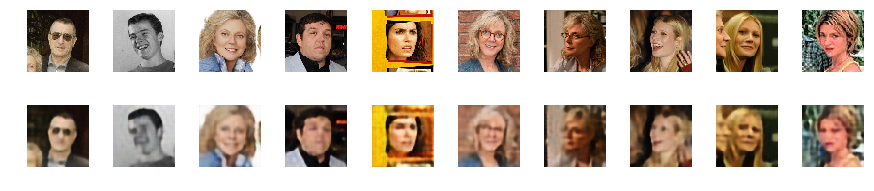

In [30]:
plot_compare(example_images)

## Traitement des images

In [31]:
"""
Network params (inputs/outputs)
"""
image_shape = (64, 64, 3)  # input image size
input_shape = image_shape
n_y = num_cat_age + 2  # labels dim


In [32]:
def image_generator():

        X = []
        y_age = []
        y_gender = []
        idx_list=[]
        for idx, row in df.iterrows():
            # images
            image_path = os.path.join(images_path, row['image_names'])
            image_array = _imread(image_path)
            image_array = _imresize(image_array, image_shape[:2])
            image_array = preprocessing_img(image_array)
            X.append(image_array)
                           
            # labels
            y_gender.append(row['gender_classes'])
            y_age.append(row['age_cat'])
            idx_list.append(idx)
            
            
            if len(X) == BATCH_SIZE :     
                    # images
                    X = np.asarray(X)
                    
                    # labels
                    y_age = to_categorical(y_age, num_classes=num_cat_age)
                    y_gender = np.array(y_gender).reshape(-1, 1)
                    y_gender = to_categorical(y_gender, num_classes=2)
                    Y = np.hstack((y_age,y_gender))
                    
                    yield X, Y, idx_list
                    X = []
                    y_age = []
                    y_gender = []
                    idx_list= []
                    
                
        if len(X) > 0 : 
                # images
                X = np.asarray(X)

                # labels
                y_age = to_categorical(y_age, num_classes=num_cat_age)
                y_gender = np.array(y_gender).reshape(-1, 1)
                y_gender = to_categorical(y_gender, num_classes=2)
                Y = np.hstack((y_age,y_gender))

                yield X, Y, idx_list

## Predictions sur toutes les images avec label et enregistrement du vecteur obtenu

On va calculer pour chacune des images du dataset le vecteur en sortie de l'encodeur, pour pouvoir ensuite calculer le vecteur moyen par classe, qui va nous servir ensuite pour la modification des images.

In [33]:
def calculate_encoder_output_vector():
    ##Creation du numpy array
    global encoder_output_vector
    
    img_gen = image_generator()

    for (images_batch, y_batch, idx) in img_gen :
        print(images_batch)
        #print(test.shape)  #(512, 64)
        print(encoder_output_vector[idx,:].shape)
        encoder_output_vector[idx,:]=encoder.predict_on_batch([images_batch])
        print(encoder_output_vector[idx,:])
        #encoder_output_vector=np.concatenate((encoder_output_vector, encoder.predict_on_batch([images_batch])))

In [34]:
#Construction du numpy array contenant les vecteurs des outputs de l'encoder

import os.path
from os import path

if path.exists("array/encoder_vector.npy"):
    encoder_output_vector = np.load('array/encoder_vector.npy', allow_pickle=True)
    
else :
    from tempfile import TemporaryFile
    encoder_vector = TemporaryFile()

    encoder_output_vector= np.empty((df.shape[0],Z_DIM))
    calculate_encoder_output_vector()
    
    np.save('array/encoder_vector.npy', encoder_output_vector)

## Calcul du vecteur moyen par classe

In [35]:
def mean_vector(vector):
    len_i=len(vector)
    len_j=len(vector[0])
    return([sum(vector[i][j] for i in range(len_i))/len_i for j in range(len_j)])

In [36]:
#Gender class0

#df.loc[df['column_name'] == some_value]

vector_gender_class0 = []

test = df.loc[df['gender_classes'] == 0.0]
print(test.shape)

for idx, row in df.loc[df['gender_classes'] == 0.0].iterrows() :
    vector_gender_class0.append(encoder_output_vector[idx])
    
len_i=len(vector_gender_class0)
len_j=len(vector_gender_class0[0])

mean_vector_gender_class0 = [sum(vector_gender_class0[i][j] for i in range(len_i))/len_i for j in range(len_j)]
print(np.array(mean_vector_gender_class0).shape)

(33101, 5)
(512,)


In [37]:
#Gender class1

vector_gender_class1 = []

test = df.loc[df['gender_classes'] == 1.0]
print(test.shape)

for idx, row in df.loc[df['gender_classes'] == 1.0].iterrows() :
    vector_gender_class1.append(encoder_output_vector[idx])
    
len_i=len(vector_gender_class1)
len_j=len(vector_gender_class1[0])

mean_vector_gender_class1 = [sum(vector_gender_class1[i][j] for i in range(len_i))/len_i for j in range(len_j)]
print(np.array(mean_vector_gender_class1).shape)

(32210, 5)
(512,)


In [38]:
#age class0

vector_age_class0 = []

test = df.loc[df['age_cat'] == 0.0]
print(test.shape)

for idx, row in df.loc[df['age_cat'] == 0.0].iterrows() :
    vector_age_class0.append(encoder_output_vector[idx])
    
len_i=len(vector_age_class0)
len_j=len(vector_age_class0[0])

mean_vector_age_class0 = [sum(vector_age_class0[i][j] for i in range(len_i))/len_i for j in range(len_j)]
print(np.array(mean_vector_age_class0).shape)

(5536, 5)
(512,)


In [39]:
#age class1

vector_age_class1 = []

test = df.loc[df['age_cat'] == 1.0]
print(test.shape)

for idx, row in df.loc[df['age_cat'] == 1.0].iterrows() :
    vector_age_class1.append(encoder_output_vector[idx])
    
len_i=len(vector_age_class1)
len_j=len(vector_age_class1[0])

mean_vector_age_class1 = [sum(vector_age_class1[i][j] for i in range(len_i))/len_i for j in range(len_j)]
print(np.array(mean_vector_age_class1).shape)

(18600, 5)
(512,)


In [40]:
#age class2

vector_age_class2 = []

test = df.loc[df['age_cat'] == 2.0]
print(test.shape)

for idx, row in df.loc[df['age_cat'] == 2.0].iterrows() :
    vector_age_class2.append(encoder_output_vector[idx])
    
len_i=len(vector_age_class2)
len_j=len(vector_age_class2[0])

mean_vector_age_class2 = [sum(vector_age_class2[i][j] for i in range(len_i))/len_i for j in range(len_j)]
print(np.array(mean_vector_age_class2).shape)

(21340, 5)
(512,)


In [41]:
#age class3

vector_age_class3 = []

test = df.loc[df['age_cat'] == 3.0]
print(test.shape)

for idx, row in df.loc[df['age_cat'] == 3.0].iterrows() :
    vector_age_class3.append(encoder_output_vector[idx])
    
len_i=len(vector_age_class3)
len_j=len(vector_age_class3[0])

mean_vector_age_class3 = [sum(vector_age_class3[i][j] for i in range(len_i))/len_i for j in range(len_j)]
print(np.array(mean_vector_age_class3).shape)

(12021, 5)
(512,)


In [42]:
#age class4

vector_age_class4 = []

test = df.loc[df['age_cat'] == 4.0]
print(test.shape)

for idx, row in df.loc[df['age_cat'] == 4.0].iterrows() :
    vector_age_class4.append(encoder_output_vector[idx])
    
len_i=len(vector_age_class4)
len_j=len(vector_age_class4[0])

mean_vector_age_class4 = [sum(vector_age_class4[i][j] for i in range(len_i))/len_i for j in range(len_j)]
print(np.array(mean_vector_age_class4).shape)

(4860, 5)
(512,)


In [43]:
#age class5

vector_age_class5 = []

test = df.loc[df['age_cat'] == 5.0]
print(test.shape)

for idx, row in df.loc[df['age_cat'] == 5.0].iterrows() :
    vector_age_class5.append(encoder_output_vector[idx])
    
len_i=len(vector_age_class5)
len_j=len(vector_age_class5[0])

mean_vector_age_class5 = [sum(vector_age_class5[i][j] for i in range(len_i))/len_i for j in range(len_j)]
print(np.array(mean_vector_age_class5).shape)

(2954, 5)
(512,)


In [44]:
mean_vector_gender_class0=np.array(mean_vector_gender_class0)
mean_vector_gender_class1=np.array(mean_vector_gender_class1)

mean_vector_age_class0=np.array(mean_vector_age_class0)
mean_vector_age_class1=np.array(mean_vector_age_class1)
mean_vector_age_class2=np.array(mean_vector_age_class2)
mean_vector_age_class3=np.array(mean_vector_age_class3)
mean_vector_age_class4=np.array(mean_vector_age_class4)
mean_vector_age_class5=np.array(mean_vector_age_class5)

np.save('array/mean_vector_gender_class0.npy', mean_vector_gender_class0)
np.save('array/mean_vector_gender_class1.npy', mean_vector_gender_class1)

np.save('array/mean_vector_age_class0.npy', mean_vector_age_class0)
np.save('array/mean_vector_age_class1.npy', mean_vector_age_class1)
np.save('array/mean_vector_age_class2.npy', mean_vector_age_class2)
np.save('array/mean_vector_age_class3.npy', mean_vector_age_class3)
np.save('array/mean_vector_age_class4.npy', mean_vector_age_class4)
np.save('array/mean_vector_age_class5.npy', mean_vector_age_class5)



Les calculs à partir des vecteurs moyens sont ensuite effectués dans le script main_ae.py

###### Debug code

(1, 64, 64, 3)
mean : -0.017883975
mean modified :  -0.056702127299394826
(1, 512)
mean modified :  -0.01788397505879407
(1, 64, 64, 3)


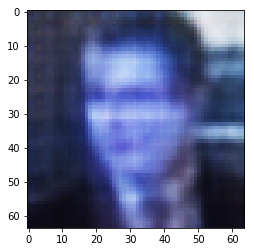

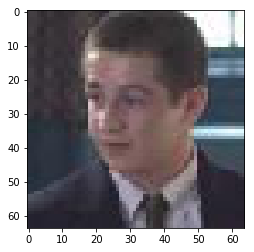

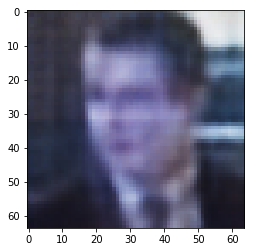

In [45]:
example_batch = next(data_flow_train)
example_batch = example_batch[0]

example_image = example_batch[3:4]

print(example_image.shape)

img_encoded = encoder.predict(example_image)
img_decoded = decoder.predict(np.reshape(mean_vector_age_class5, (1,Z_DIM))+(img_encoded))
# img_decoded = decoder.predict(img_encoded)


print("mean :", np.mean(img_encoded))
vector_modified = 2*mean_vector_age_class5+(img_encoded)
print("mean modified : ", np.mean(vector_modified))

mean = np.mean(img_encoded)
mean_modif = np.mean(vector_modified)

vector_modified[:] = [i+(mean - mean_modif) for i in vector_modified]

print(vector_modified.shape)
    
print("mean modified : ", np.mean(vector_modified))

img_decoded_modified = decoder.predict(vector_modified)
plt.figure()
plt.imshow(img_decoded_modified[0])


import matplotlib
print(img_decoded.shape)
matplotlib.image.imsave('name.jpg', img_decoded[0])

##Tentative de retirer la dernière coordonnée pour le .jpg
img_decoded = matplotlib.pyplot.imread('name.jpg', format=None)
img_decoded = img_decoded[:, :, :3]
######


plt.figure()
plt.imshow(example_image[0])

plt.figure()
plt.imshow(img_decoded)


# ##############################################
# #Reshaping pour correspondre à ce qui est voulu
# test = np.reshape(encoder_output_vector[10], (1,Z_DIM))

# img_decoded = decoder.predict(test)
# plt.figure()
# plt.imshow(img_decoded[0])
# matplotlib.image.imsave('test.jpg', img_decoded[0])




# #Reconstruction en femme
# test = np.reshape(mean_vector_gender_class0, (1,Z_DIM))

# img_decoded = decoder.predict(test)     #vecteur moyen
# img_decoded = decoder.predict(np.reshape(mean_vector_gender_class0, (1,Z_DIM))+np.reshape(encoder_output_vector[10], (1,Z_DIM)))     #Image + vecteur moyen

# print(np.array(img_decoded[0]).shape)
# matplotlib.image.imsave('test2.jpg', img_decoded[0])
# #img_decoded = decoder.predict(test)
# plt.figure()
# plt.imshow(img_decoded[0])


In [46]:
#For debug purposes

img_gen = image_generator()

for (images_batch, y_batch, idx) in img_gen :
    #print(test.shape)  #(512, 64)
    test = encoder.predict_on_batch([images_batch])
    test=test[0]
    print(test.shape)
    test2 = decoder.predict([[test]], batch_size=None)
    print(test2.shape)
    break

(512,)
(1, 64, 64, 3)
